# NEGF Tutorial 
##  Local Density of States calcilation using NEGF 

$LDOS = \sum_i$

In [46]:
%matplotlib inline
import numpy as np
from scipy.linalg import inv
import math
import cmath 
import matplotlib.pyplot as plt
from numpy.lib.scimath import sqrt as csqrt

In [47]:
# Physical Constants
h    =   6.582119514e-16    # Plank's constant [eV*s]
hh   =   1.0545718e-34      # Plank's constant [J*s]
m0   =   9.11e-31           # Electron Mass [kg]
q    =   1.6e-19            # Elementary Charge [C]
kT   =   8.6173e-5*300      # Boltzmann constant kB multiplied by temperature T=300K


In [48]:
# Parameters GaAs
Eg    = 1.420               # conduction band gap [eV]
m_eff = 0.067*m0            # effective mass [kg]
eps   = 13.1*8.85e-12       # permittivity eps*eps_0 [F/m]

In [49]:
# Structure 
Nx       =  40               # number of spatial grid points  
dx       =  1.2*1e-9         # delta x in [m] (total nanowire lenght is dx*Nx)


# Energy discretized

Emin = Eg-0.22                      # energy interval [eV]
Emax = Eg+0.58

NE = 500                            # number of energy grid points
E  = np.linspace(Emin, Emax, NE);   # energy grid
dE = E[1] - E[0] 
gamma = 1e-15j                      # small complex parameter gamma Eq.(43)

# k-points (transverse momentum)
k_max = (1.5/1e-9)
NK = 800                            # number of k grid points
k_point = np.linspace(0,k_max,NK)
dk = k_point[1] - k_point[0]


In [50]:
# transverse energies E_k = h^2k^2/2m0 Eq.(7)
E_k = h*hh*k_point ** 2/(2*m_eff)

# H and W matrices (bulk Hamiltonian)
H0 = np.zeros(NK)
H0 =  Eg + 0.5*(h*hh/m_eff)*( 2/dx**2 + k_point**2 );  
W  =  -0.5*(h*hh/m_eff)/dx**2; 



In [51]:
# Construct the main Hamiltonian matrix T
T = np.zeros((Nx,Nx,NK))

for k in range(NK):
    T[:,:,k] = H0[k]*np.diag(np.ones(Nx),0) + \
                       W*np.diag(np.ones(Nx-1),-1) + \
                          W*np.diag(np.ones(Nx-1),1)


In [52]:
 # Green's functions
   
 G_R    = np.zeros((Nx,Nx,NK),dtype=np.complex128)   # retarded Green's function
BSE_L  = np.zeros((Nx,Nx,NK),dtype=np.complex128)    # boundary self-energy lesser (left)
BSE_R  = np.zeros((Nx,Nx,NK),dtype=np.complex128)    # boundary self-energy lesser (right)  

GamL = np.zeros((Nx,Nx,NK),dtype=np.complex128)      # Level broadening functions
GamR = np.zeros((Nx,Nx,NK),dtype=np.complex128)
  
LDOS_3D =  np.zeros((Nx,NE))
LDOS_1D =  np.zeros((Nx,NE))

kLR    = np.zeros(NK,dtype=np.complex128)
sig_LR = np.zeros(NK,dtype=np.complex128)

In [53]:
print('Energy iteration number\n', end='')
for EnergyIter in range(NE):
    for k in range(NK):
        # Wavenumbers from dispersion relation
            kLR[k]   =  (1/(dx))*cmath.acos(1 - m_eff*dx**2*(E[EnergyIter] - Eg - E_k[k])/(h*hh))
            kLR.imag = np.absolute(kLR.imag)
        # Boundary conditions (corner elements)
            sig_LR[k] = - h*hh/(2*m_eff*dx**2)*cmath.exp(1j*kLR[k]*dx);
        # Boundary self-energies lesser (left and right)
            BSE_L[0,0,k]         = sig_LR[k]
            BSE_R[Nx-1,Nx-1,k]   = sig_LR[k]
    
    # Ballistic Green's function integrated wrt k
    G_R_T  =  np.zeros((Nx,Nx),dtype=np.complex128)
    for k in range(NK):
             G_R[:,:,k] = inv((E[EnergyIter]+gamma)*np.eye(Nx) - T[:,:,k] - \
                              BSE_L[:,:,k] - BSE_R[:,:,k])
             G_R_T = G_R_T + (dk/math.pi)*k_point[k]*G_R[:,:,k]
    # Dyson equation
    # LDOS approximated by Green's functions Eq.(23)
    
    for SpaceGrid in range(Nx):
        LDOS_1D[SpaceGrid,EnergyIter] = - 1/(math.pi*dx) * G_R[SpaceGrid,SpaceGrid,0].imag;
        LDOS_3D[SpaceGrid,EnergyIter] = - 1/(math.pi*dx) * G_R_T[SpaceGrid,SpaceGrid].imag;
        
    
    print("\r%3d out of" % (EnergyIter+1), str(NE), end='')
print('\nDONE....')     
#Analytical expressions
def ldos1D(x):
     return 1/(math.pi*h*math.sqrt(q))*(csqrt(m_eff/(2*(x-Eg))).real)
def ldos3D(x):
     return  1/(2*math.pi**2*q**(3/2))*(2*m_eff/h**2)**(3/2)*(csqrt(E - Eg)).real
    
    
    


Energy iteration number
500 out of 500
DONE....


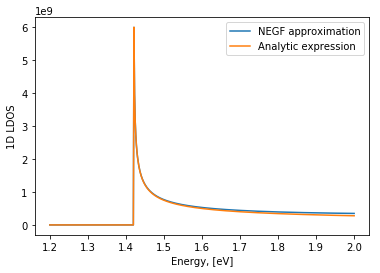

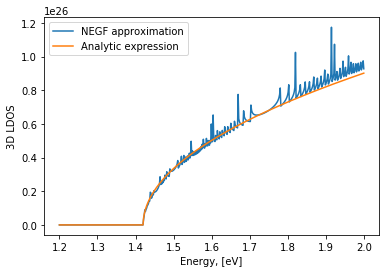

In [54]:

plt.plot(E,LDOS_1D[2,:],E, ldos1D(E))
plt.ylabel('1D LDOS')
plt.xlabel('Energy, [eV]')
plt.legend( ('NEGF approximation', 'Analytic expression'), loc='upper right')
plt.show()
plt.plot(E, LDOS_3D[2,:],E,ldos3D(E))
plt.ylabel('3D LDOS')
plt.xlabel('Energy, [eV]')
plt.legend( ('NEGF approximation', 'Analytic expression'), loc='upper left')
plt.show()
